<a href="https://colab.research.google.com/github/suneelkumarpentela/Normalizer-free-models/blob/master/NF_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support

In [113]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch'

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Mathlogic")

In [116]:
train = pd.read_csv("./Data/train.csv")
print(train.shape)

(90000, 95)


In [117]:
train['target_new'] = np.where(train['target']==0,0,1)
train.drop(['target'],axis=1,inplace=True)

In [118]:
val = pd.read_csv("./Data/valid.csv")
print(val.shape)
val['target_new'] = np.where(val['target']==0,0,1)
val.drop('target',axis=1,inplace=True)

(29000, 95)


In [119]:
test = pd.read_csv("./Data/test.csv")
print(test.shape)
test['target_new'] = np.where(test['target']==0,0,1)
test.drop('target',axis=1,inplace=True)

(29580, 95)


In [120]:
frames = [train,test]
X = pd.concat(frames)

In [121]:
X_train = X.drop('target_new',axis=1)
y_train = np.array([X['target_new']]).reshape(-1,1)
X_train.shape

(119580, 94)

In [122]:
X_test = val.drop('target_new',axis=1)
y_test = np.array([val['target_new']]).reshape(-1,1)
X_test.shape

(29000, 94)

In [123]:
a = y_test.flatten()

In [124]:
from collections import Counter

In [125]:
Counter(y_test.flatten())

Counter({0: 27488, 1: 1512})

In [126]:
Counter(y_train.flatten())

Counter({0: 113300, 1: 6280})

In [127]:
6280/(6280+113300)

0.05251714333500585

In [128]:
y_test.shape

(29000, 1)

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_np = scaler.transform(X_train)

X_test_np = scaler.transform(X_test)

In [130]:
y_train_np = y_train
y_test_np = y_test

In [131]:
X_train = torch.FloatTensor(X_train_np)

X_test = torch.FloatTensor(X_test_np)

y_train = torch.FloatTensor(y_train_np)
y_test = torch.FloatTensor(y_test_np)

In [132]:
print(y_train.shape)

torch.Size([119580, 1])


In [133]:
X_train_np.shape

(119580, 94)

In [134]:
X_test_np.shape

(29000, 94)

In [135]:
batch_size = 64
num_train_batches = int(X_train_np.shape[0]/batch_size)+1
num_test_batches = int(X_test_np.shape[0]/batch_size)+1
train_data_size = X_train_np.shape[0]
test_data_size = X_test_np.shape[0]
print("Train :",num_train_batches,train_data_size)
print("Test :",num_test_batches,test_data_size)

Train : 1869 119580
Test : 454 29000


In [136]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [137]:
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [138]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [139]:
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# print(labels.shape)

In [140]:
class WSLinear(nn.Linear):

    def __init__(self, in_channels, out_channels,bias=True):
        super().__init__(in_channels, out_channels,bias=bias)

        nn.init.kaiming_normal_(self.weight)
        self.gain = nn.Parameter(torch.ones(
            self.weight.size()[0], requires_grad=True))

    def standardize_weight(self, eps):
        mean = torch.mean(self.weight, dim=(1), keepdims=True)
        var = torch.std(self.weight, dim=(1), keepdims=True, unbiased=False) ** 2
        fan_in = torch.prod(torch.tensor(self.weight.shape))

        scale = torch.rsqrt(torch.max(
            var * fan_in, torch.tensor(eps))) * self.gain.view_as(var)
        shift = mean * scale
        return self.weight * scale - shift

    def forward(self, input, eps=1e-4):
        weight = self.standardize_weight(eps)
        return F.linear(input, weight, self.bias)

In [141]:
class nf_block(nn.Module):

  def __init__(self,alpha=0.2,beta=1.0):
    super().__init__()

    self.nn1 = WSLinear(94,64)
    self.nn2 = WSLinear(64,64)
    self.nn3 = WSLinear(64,64)
    self.nn4 = WSLinear(64,1)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu3 = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.alpha = alpha #rate of change of variance at res bock
    self.expected_std = 1.0
    self.beta = 1.0
    self.skip_gain1 = nn.Parameter(torch.zeros(()))
    self.skip_gain2 = nn.Parameter(torch.zeros(()))

  def forward(self,x):

    x = self.nn1(x)
    x = self.relu1(x)

    shortcut1 = x

    self.beta = 1/(self.expected_std)
    out1 = x*self.beta

    out1 = self.nn2(x)
    out1 = shortcut1 + out1*self.alpha*self.skip_gain1

    self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
    out1 = self.relu2(out1)

    shortcut2 = out1

    self.beta = 1/(self.expected_std)
    out2 = out1*self.beta

    out2 = self.nn3(out1)
    out2 += shortcut2 + out2*self.alpha*self.skip_gain2
    
    self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
    out2 = self.relu3(out2)

    out3 = self.nn4(out2)
    out3 = self.sigmoid(out3)

    return out3

In [142]:
# class feedforward_nfnet(nn.Module):

#   def __init__(self,layers = [94,64,64,64,1],alpha=0.2,beta=1.0):
#     super().__init__()

#     self.layers = layers
#     self.sigmoid = nn.Sigmoid()
#     self.alpha = alpha #rate of change of variance at res bock
#     self.expected_std = 1.0
#     self.beta = 1.0

#     self.first_nn = WSLinear(self.layers[0],self.layers[1])
#     self.layer2 = 
#     self.last_nn = WSLinear(self.layers[-2],self.layers[-1])

#   def _NF_block(self,in_units,out_units,input):

#     nn = WSLinear(in_units,out_units)
#     relu = nn.ReLU()
#     sigmoid = nn.Sigmoid()
#     skip_gain = nn.Parameter(torch.zeros(()))
#     self.beta = 1/(self.expected_std)

#     shortcut = input

#     x = input*self.beta
#     x = nn(x)
#     out = shortcut + x*self.alpha*skip_gain

#     self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
#     out = relu(out)

#     return out

#   def forward(self,input):

#     x = self.first_nn(input)
#     x = nn.ReLU(x)

#     #for i in range(len(self.layers)-3):
#     # x = self._NF_block(self.layers[1],self.layers[2],x)
#     # x = self._NF_block(self.layers[2],self.layers[3],x)

#     out = self.last_nn(x)
#     out = self.sigmoid(out)

#     return out

In [143]:
class nf_block(nn.Module):

  def __init__(self,in_units,out_units,alpha,beta):
    super().__init__()

    self.nn = WSLinear(in_units,out_units)
    self.relu = nn.ReLU()

    self.alpha = alpha
    self.beta = beta
    self.skip_gain = nn.Parameter(torch.zeros(()))

  def forward(self,input):

    shortcut = input

    x = input*self.beta
    x = self.nn(x)
    out = shortcut + x*self.alpha*self.skip_gain

    out = self.relu(out)

    return out

In [144]:
class feedforward_nfnet(nn.Module):

  def __init__(self,layers = [94,64,64,64,64,64,64,64,64,64,64,64,1],alpha=0.2,beta=1.0):
    super().__init__()

    self.layers = layers
    #self.layers = [94,64,64,64,32,32,32,16,16,16,1]
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.alpha = alpha #rate of change of variance at res bock
    self.expected_std = 1.0
    self.beta = 1.0

    self.first_nn = WSLinear(self.layers[0],self.layers[1])

    blocks = []

    for i in range(len(self.layers)-3):
      self.beta = 1/(self.expected_std)
      blocks.append(nf_block(self.layers[i+1],self.layers[i+2],self.alpha,self.beta))
      self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5

    self.body = nn.Sequential(*blocks)

    self.last_nn = WSLinear(self.layers[-2],self.layers[-1])

  def forward(self,input):

    x = self.first_nn(input)
    x = self.relu(x)

    x = self.body(x)

    out = self.last_nn(x)
    out = self.sigmoid(out)

    return out

In [145]:
# model = nf_block()

In [146]:
model = feedforward_nfnet()

In [147]:
total_params = sum(p.numel() for p in model.parameters())
total_params

48460

In [148]:
print(model.forward)

<bound method feedforward_nfnet.forward of feedforward_nfnet(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (first_nn): WSLinear(in_features=94, out_features=64, bias=True)
  (body): Sequential(
    (0): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (1): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (2): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (3): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (4): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (5): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (6): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (7): nf_block(
      (nn): W

In [149]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mathlogic'

In [150]:
if(os.getcwd() != r"/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch"):
  os.chdir(r"./nfnets_pytorch")

In [151]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mathlogic/nfnets_pytorch'

In [152]:
from nfnets import SGD_AGC

In [153]:
# loss_func = nn.BCELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
loss_func = nn.BCELoss()
optimizer = SGD_AGC(
        named_params=model.named_parameters(), # Pass named parameters
        lr=1e-3,
        momentum=0.9,
        clipping=0.1, # New clipping parameter
        weight_decay=2e-5, 
        nesterov=True)

In [154]:
X_train_np.shape

(119580, 94)

In [155]:
epochs = 100

In [156]:
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  model.train()
  running_loss = 0
  running_val_loss = 0
  running_acc = 0
  running_val_acc = 0

  for i,data in enumerate(train_dataloader):
    train_x,train_y = data
    y_pred = model(train_x)
    loss = loss_func(y_pred,train_y)
    # predicted = model(torch.tensor(X_train_np,dtype=torch.float32))
    acc = (y_pred.reshape(-1).detach().numpy().round() == 
           train_y.reshape(-1).detach().numpy().round()).mean()
    running_loss += loss.item()/(num_train_batches)
    running_acc += acc/(num_train_batches)
    
    #reset grads
    optimizer.zero_grad()
    
    #backward
    loss.backward()

    #weight updates
    optimizer.step()

  print(f'Epoch: {epoch+1} Loss: {running_loss} Accuracy: {running_acc}',end = " ")

  model.eval()  
  for i,data in enumerate(test_dataloader):
    X_val,y_val = data
    y_pred_val = model(X_val)
    val_loss = loss_func(y_pred_val,y_val)
    val_acc = (y_pred_val.reshape(-1).detach().numpy().round() == 
           y_val.reshape(-1).detach().numpy().round()).mean()

    running_val_loss += val_loss.item()/(num_test_batches)
    running_val_acc += val_acc/(num_test_batches)
    
  print(f'Val Loss: {running_val_loss} Val Accuracy: {running_val_acc}')


  losses.append(running_loss)
  accuracy.append(running_acc)
  val_losses.append(running_val_loss)
  val_accuracy.append(running_val_acc)  

Epoch: 1 Loss: 0.44756251552833415 Accuracy: 0.8949531357486828 Val Loss: 0.20788483781173908 Val Accuracy: 0.9479625550660862
Epoch: 2 Loss: 0.20300963331450447 Accuracy: 0.9474688049377072 Val Loss: 0.1991403619738271 Val Accuracy: 0.9479625550660862
Epoch: 3 Loss: 0.19866090904723988 Accuracy: 0.9474771650233131 Val Loss: 0.19665881211865327 Val Accuracy: 0.9477216409691698
Epoch: 4 Loss: 0.19624491938459135 Accuracy: 0.947477165023313 Val Loss: 0.19405065662338367 Val Accuracy: 0.9479625550660863
Epoch: 5 Loss: 0.19452476235372707 Accuracy: 0.9474879137048109 Val Loss: 0.1926413846616571 Val Accuracy: 0.9479625550660862
Epoch: 6 Loss: 0.19324837711730902 Accuracy: 0.9474771650233148 Val Loss: 0.19149745245041558 Val Accuracy: 0.947962555066086
Epoch: 7 Loss: 0.1921667728280085 Accuracy: 0.9474879137048093 Val Loss: 0.1905791826611836 Val Accuracy: 0.9479625550660861
Epoch: 8 Loss: 0.19131954752183866 Accuracy: 0.9474771650233148 Val Loss: 0.19051612141472377 Val Accuracy: 0.9477216

Text(0, 0.5, 'loss')

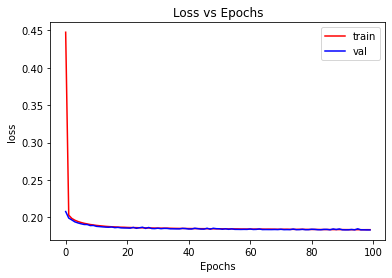

In [157]:
plt.plot(losses,'r',label='train')
plt.plot(val_losses,'b',label='val')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

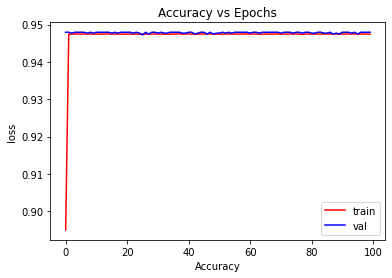

In [158]:
plt.plot(accuracy,'r',label='train')
plt.plot(val_accuracy,'b',label='val')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [159]:
model.eval()
preds_train = []
with torch.no_grad():
   for i,data in enumerate(train_loader):
     trainx,trainy = data
     y_hat = model.forward(trainx)
     preds_train.append(y_hat)

In [160]:
preds_train = np.array(preds_train)
preds_train

array([0.06302144, 0.00466951, 0.0366246 , ..., 0.02942211, 0.02463348,
       0.05147825], dtype=float32)

In [161]:
def best_f1(preds,y_test_np):
  f1_max = 0
  cutoff = -1
  for i in np.arange(0.01,1,0.01):
    preds1 = (preds>=i)*1 
    #print(sum(preds1))
    f1_score = sklearn.metrics.precision_recall_fscore_support(preds1,y_test_np)[2][1]
    print(f1_score)
    if (not f1_score):
      break
    if (f1_score > f1_max):
      f1_max = f1_score
      cutoff = i
  return cutoff,f1_max

In [162]:
train_cutoff,train_f1 = best_f1(preds_train,y_train_np)

0.11504457790875518
0.13309143036330243
0.14931347824346503
0.16351412765824075
0.1757434741510943
0.18756186424615123
0.19722612273052004
0.2056999011058168
0.21674320560114435
0.22077562326869804
0.22026672496720595
0.2167356029271397
0.21106185042517625
0.20214320506575742
0.18775729371755862
0.17807816632383192
0.16712328767123288
0.1502942507922137
0.13545530692832355
0.11786928598413299
0.1064388961892247
0.08902321747492788
0.0757876809537326
0.059157802710185045
0.04558319678236258
0.03785584494245911
0.02792267566738263
0.021695335502866883
0.01590271281571562
0.012537219871493498
0.0091324200913242
0.007891414141414142
0.0066413662239089176
0.004437400950871632
0.0031735956839098697
0.0022229279136233722
0.0019068806610519626
0.001589319771137953
0.0009540467482906661
0.0006361323155216284
0.0003182179793158313
0.0003182179793158313
0.00031826861871419476
0.00031826861871419476
0.0003183192742320547
0.0003183192742320547
0.0003183192742320547
0.00031836994587710915
0.00031836

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
train_cutoff,train_f1

(0.09999999999999999, 0.22077562326869804)

In [164]:
preds_train_ideal = (preds_train>=train_cutoff)*1

In [165]:
print(classification_report(preds_train_ideal,y_train_np))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    104200
           1       0.38      0.16      0.22     15380

    accuracy                           0.86    119580
   macro avg       0.63      0.56      0.57    119580
weighted avg       0.82      0.86      0.83    119580



In [166]:
model.eval()
preds = []
with torch.no_grad():
   for i,data in enumerate(test_loader):
     test_x,test_y = data
     y_hat = model.forward(test_x)
     preds.append(y_hat)

In [167]:
np.array(preds)

array([0.0261362 , 0.011601  , 0.2078072 , ..., 0.09130067, 0.07971888,
       0.09565134], dtype=float32)

In [168]:
preds = np.array(preds)
# preds[preds>=0.5] = 1
# preds[preds<=0.5] = 0


In [169]:
np.unique(preds)

array([1.9784120e-05, 3.2744741e-05, 4.9837192e-05, ..., 3.9713138e-01,
       3.9772868e-01, 4.2165336e-01], dtype=float32)

In [170]:
preds_dummy = (preds>=0.5)*1

In [171]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1., 0.]),
 array([0.94786207, 0.        ]),
 array([0.97323325, 0.        ]),
 array([29000,     0]))

In [172]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)[2][1]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [173]:
np.arange(0.01,1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [174]:
cutoff,f1_max = best_f1(preds,y_test_np)

0.11395725638453826
0.13104278570105576
0.1475835404584369
0.16231996885947841
0.17341819543242232
0.18607892673577836
0.19791561266821817
0.20778582831880144
0.2129798903107861
0.2171450151057402
0.21436562989483107
0.2062176165803109
0.20053238686779062
0.19610432485968968
0.19277108433734938
0.17722534081796312
0.16241900647948163
0.13986013986013984
0.127826941986234
0.10892116182572616
0.0992984349703184
0.08243929983060419
0.07009345794392523
0.059000602046959665
0.046798029556650245
0.037641154328732745
0.02926208651399491
0.021822849807445442
0.019404915912031043
0.014294996751137101
0.01042345276872964
0.009156311314584695
0.009168303863785199
0.00788436268068331
0.005263157894736841
0.003949967083607636
0.0


In [175]:
print(cutoff,f1_max)

0.09999999999999999 0.2171450151057402


In [176]:
preds_ideal = (preds>=cutoff)*1

In [177]:
print(classification_report(preds_ideal,y_test_np))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     25216
           1       0.38      0.15      0.22      3784

    accuracy                           0.86     29000
   macro avg       0.63      0.56      0.57     29000
weighted avg       0.82      0.86      0.83     29000

